In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# change working DIR
import os
os.chdir("/content/drive/MyDrive/Deep Learning")

In [3]:
!dir

Data  happy\ test.jpg  logs  sad\ test.jpg  Untitled0.ipynb


##1.1 Install Dependencies and Setup

In [4]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [5]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bidict                           0.23.1

In [6]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [8]:
len(gpus)

1

In [9]:
#Avoid OOM error by setting GPU Memory Consuption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

##1.2 Remove dodgy image

In [10]:
import cv2
import imghdr

In [11]:
data_dir = 'Data'

In [12]:
os.listdir(data_dir)

['happy people images', 'sad people images']

In [13]:
image_exts = ['jpeg', 'jpg', 'png', 'bmp']

In [14]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

##1.3 Load Data

In [15]:
import numpy as np
from matplotlib import pyplot as plt

In [16]:
tf.keras.utils.image_dataset_from_directory??

In [17]:
data = tf.keras.utils.image_dataset_from_directory('Data')

Found 70 files belonging to 2 classes.


In [18]:
data_iterator = data.as_numpy_iterator()

In [19]:
#Get another batch from the iterator
batch = data_iterator.next()

In [20]:
#Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

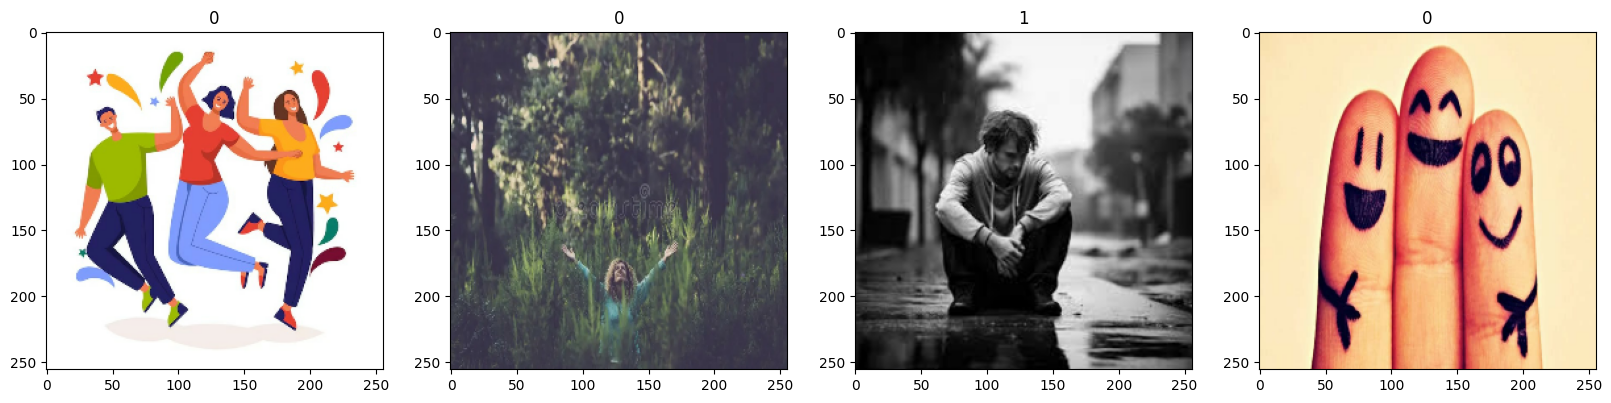

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

###Label happy represented by 0 and sad represented by 1

#2. Preprocess Data

##2.1 Scale Data

In [22]:
data = data.map(lambda x, y: (x/255, y))

In [23]:
scaled_iterator = data.as_numpy_iterator()

In [24]:
batch = scaled_iterator.next()

In [25]:
batch[0].max()

1.0

##2.2 Split data

In [26]:
len(data) #3 batches each contain 32 images

3

In [27]:
train_size = int(len(data)*.7) #70%
val_size = int(len(data)*.2)+1  #20%
test_size = int(len(data)*.1)+1 #10%

In [28]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

#3. Deep Model

##3.1 Build Deep Learning Model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [30]:
model = Sequential()

In [31]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))  # 16 kernel 3*3 stried 1
model.add(MaxPooling2D()) #Default MaxPooling kernel is 2*2

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))  # Fully connected layer
model.add(Dense(1, activation='sigmoid'))

In [32]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy']) # Optimizer= adam, loss function= BinaryCrossentropy

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

##3.2 Train

In [34]:
logdir = 'logs'

In [35]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [36]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
2/2 [==============================] - 8s 751ms/step - loss: 0.6491 - accuracy: 0.5156 - val_loss: 0.6858 - val_accuracy: 0.5000
Epoch 2/10
2/2 [==============================] - 1s 357ms/step - loss: 0.6049 - accuracy: 0.6875 - val_loss: 0.4933 - val_accuracy: 1.0000
Epoch 3/10
2/2 [==============================] - 1s 271ms/step - loss: 0.4957 - accuracy: 0.9219 - val_loss: 0.3251 - val_accuracy: 0.8333
Epoch 4/10
2/2 [==============================] - 1s 280ms/step - loss: 0.4192 - accuracy: 0.8125 - val_loss: 0.2588 - val_accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 1s 298ms/step - loss: 0.4046 - accuracy: 0.8125 - val_loss: 0.1255 - val_accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 1s 301ms/step - loss: 0.2261 - accuracy: 0.9219 - val_loss: 0.4258 - val_accuracy: 0.8333
Epoch 7/10
2/2 [==============================] - 1s 291ms/step - loss: 0.2547 - accuracy: 0.8906 - val_loss: 0.0847 - val_accuracy: 1.0000
Epoch 8/10
2/2 [====

##3.3 Plot Performance

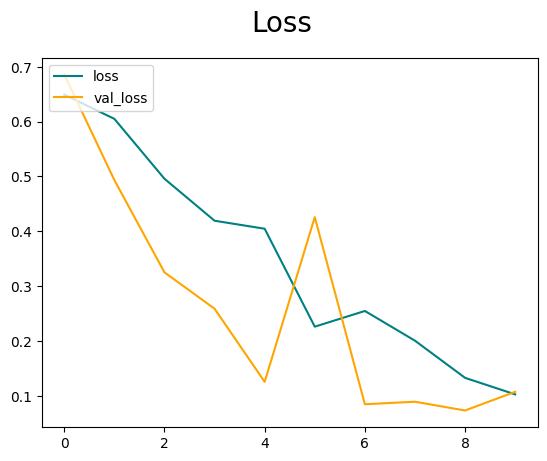

In [37]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

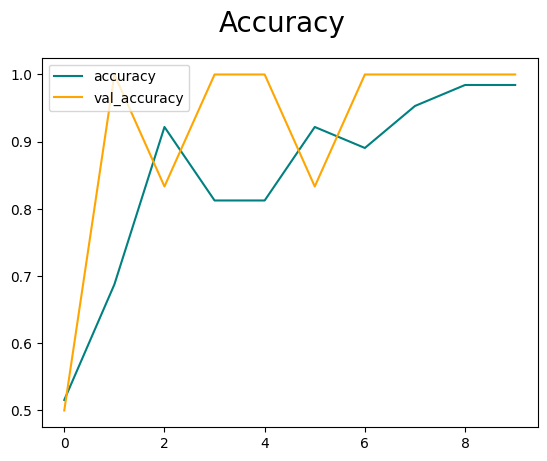

In [38]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#4. Evaluate Performance

4.1 Evaluate

In [39]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [40]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [41]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [42]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.0, Recall:0.0, Accuracy:0.0


##4.2 Test

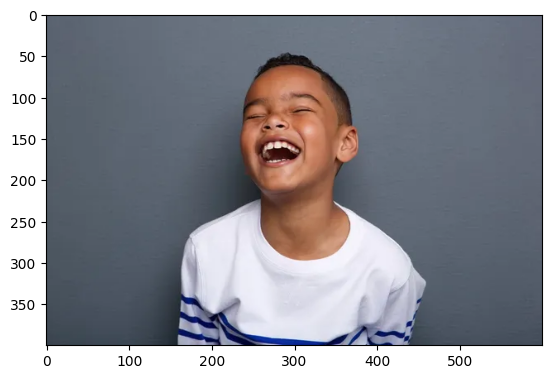

In [43]:
img = cv2.imread('happy test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

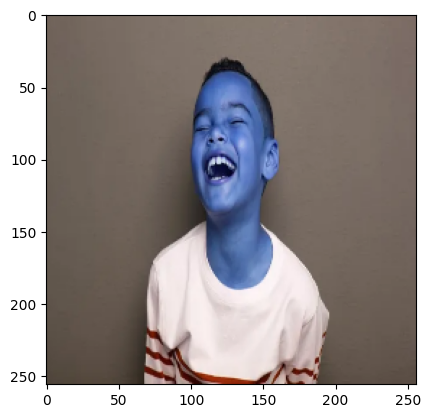

In [44]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [45]:
resize.shape

TensorShape([256, 256, 3])

In [46]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [47]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 299ms/step


In [48]:
yhat

array([[0.13971826]], dtype=float32)

In [49]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


#5. Save the Model

##5.1

In [50]:
from tensorflow.keras.models import load_model

In [51]:
model.save(os.path.join('models', 'happysadmodel.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
new_model = load_model(os.path.join('models', 'happysadmodel.h5'))

In [54]:
yhat_new = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 19ms/step


In [55]:
if yhat_new > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy
